# **Modeling and Evaluating Notebook**

## Objectives

The primary objective of this notebook is to address Business Requirement 2: building and evaluating a model to predict whether a cherry leaf is healthy or affected by powdery mildew. The notebook will guide you through the following steps:

1. **Data Loading and Preprocessing**: Load and prepare image data for model training.
2. **Model Architecture Definition**: Define a Convolutional Neural Network (CNN) model suitable for image classification.
3. **Training Process**: Train the CNN model and visualize the training progress.
4. **Validation and Test Evaluations**: Evaluate the model's performance on validation and test datasets.
5. **Result Visualization**: Visualize model predictions and performance metrics.

### Relevant Resources:

- [Convolutional Neural Networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn): Learn more about CNNs, which are used for image classification tasks.
- [TensorFlow Documentation](https://www.tensorflow.org/api_docs): Official documentation for TensorFlow, the library used for building and training models.
- [Keras Documentation](https://keras.io/): Keras is a high-level API for building and training deep learning models in TensorFlow.

## Inputs

The notebook uses the following inputs:

- **Dataset**: The dataset contains images of cherry leaves, categorized as either healthy or affected by powdery mildew. It is divided into three subsets:
  - **Train Set**: `inputs/cherry-leaves_dataset/cherry-leaves/train` - Used to train the model.
  - **Validation Set**: `inputs/cherry-leaves_dataset/cherry-leaves/validation` - Used to validate the model during training and tune hyperparameters.
  - **Test Set**: `inputs/cherry-leaves_dataset/cherry-leaves/test` - Used to evaluate the final performance of the model.

- **Image Shape Embedding**: 
  - **File**: `outputs/v1/image_shape.pkl`
  - **Description**: This pickle file contains the average shape of the images, ensuring all images are processed consistently during model training and evaluation.

- **Class Indices**: 
  - **File**: `outputs/v1/class_indices.pkl`
  - **Description**: This pickle file stores the mapping of class labels to integer indices, crucial for interpreting the model's predictions.

### Relevant Resources:

- [Understanding Data Splits (Train, Validation, Test)](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7): An overview of why data is split into these three sets and how they are used in machine learning projects.
- [Pickle File Documentation](https://docs.python.org/3/library/pickle.html): Learn more about Python's pickle module, which is used for serializing and de-serializing Python objects.

## Outputs

By the end of this notebook, you will produce the following outputs:

- **Data Preprocessing Steps**: Processed and augmented image datasets ready for model training, validation, and testing.
- **Model Architecture**: A Convolutional Neural Network (CNN) model defined and compiled for binary classification of cherry leaves.
- **Training Progress**: Plots showing the loss and accuracy metrics during the training process, saved as images.
  - **Files**: `outputs/v1/model_training_losses.png`, `outputs/v1/model_training_acc.png`
- **Model Evaluation**: Final evaluation metrics of the model on the test set, including accuracy and loss.
  - **File**: `outputs/v1/evaluation.pkl`
- **Saved Model**: The trained model saved for future predictions.
  - **File**: `outputs/v1/cherry_leaves_model.h5`
- **Result Visualization**: Visualizations of the model's predictions on new data, allowing for visual inspection of the model's performance.


## Additional Comments



---

# Import necessary libraries

In this section, we import several libraries essential for data manipulation, visualization, and building deep learning models. Below are some links to the official documentation for each library:

- [NumPy Documentation](https://numpy.org/doc/stable/): For numerical operations and array handling.
- [Pandas Documentation](https://pandas.pydata.org/pandas-docs/stable/): For data manipulation and analysis.
- [Matplotlib Documentation](https://matplotlib.org/stable/contents.html): For creating static, animated, and interactive visualizations in Python.
- [Seaborn Documentation](https://seaborn.pydata.org/): For statistical data visualization based on Matplotlib.
- [TensorFlow Documentation](https://www.tensorflow.org/api_docs): For building and training deep learning models.
- [Keras Documentation](https://keras.io/): For building neural networks using Keras, a high-level API in TensorFlow.
- [scikit-learn Documentation](https://scikit-learn.org/stable/documentation.html): For evaluating model performance using metrics like confusion matrices and classification reports.


In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Working directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/rare-and-sweet')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/rare-and-sweet'

---

# Section 1

## Set input directories

In [5]:
my_data_dir = 'inputs/cherry-leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directories

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(114, 114, 3)

---

# Section 2

## Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




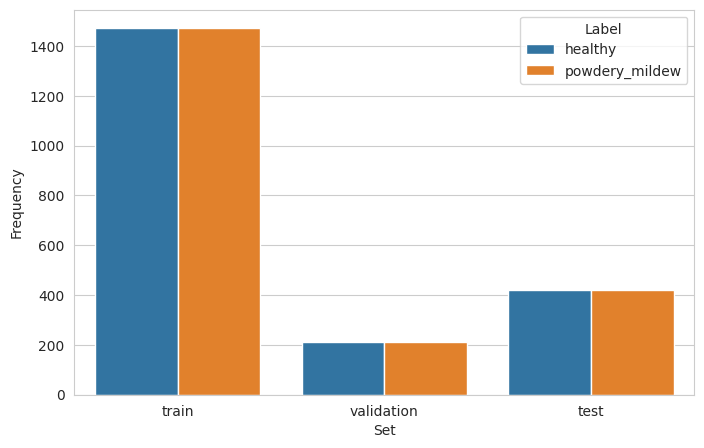

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()


## Image data augmentation

In this section, we perform data augmentation to increase the diversity of our training data. Data augmentation helps to improve the generalization of the model by applying random transformations to the training images.

### Relevant Resources:
- [ImageDataGenerator Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator): Learn more about the `ImageDataGenerator` class in TensorFlow, which allows for real-time data augmentation.


**Intiatize ImageDataGenerator**

In [10]:
# Initialize ImageDataGenerator with augmentation options
augmented_image_data = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

**Augment training image dataset**

In [11]:
batch_size = 16 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment validation image dataset**

In [12]:
batch_size = 16
validation_set = augmented_image_data.flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

train_set.class_indices 

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Augment test image dataset**

In [13]:
batch_size = 16
test_set = augmented_image_data.flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

train_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

**Plot augmented training image**

(16, 114, 114, 3)


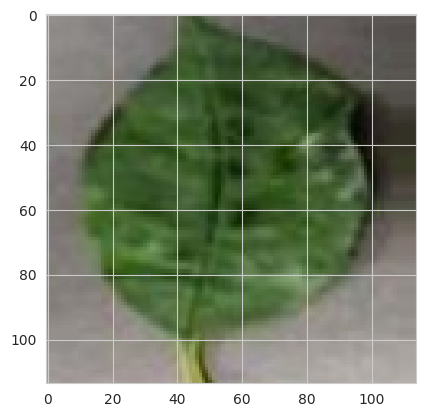

(16, 114, 114, 3)


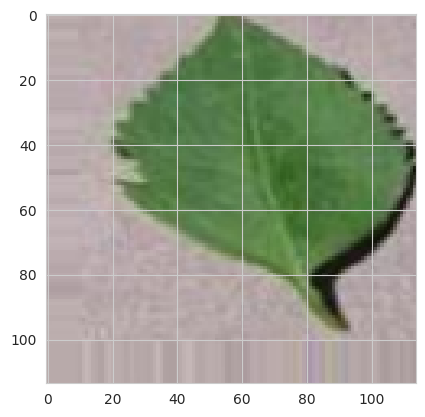

(16, 114, 114, 3)


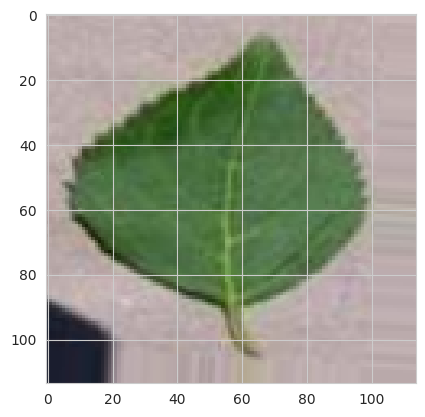

In [14]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,114,114,3)
    plt.imshow(img[0])
    plt.show()

**Plot Validation Augmented Images**

(16, 114, 114, 3)


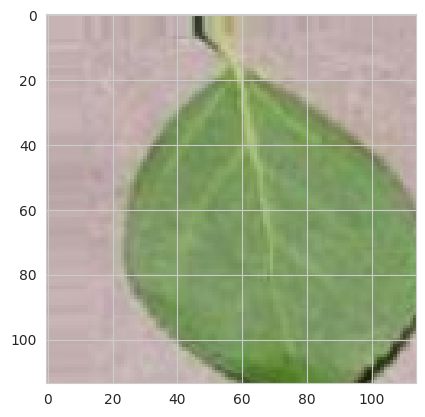

(16, 114, 114, 3)


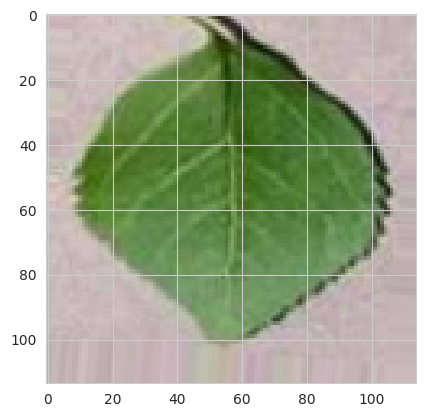

(16, 114, 114, 3)


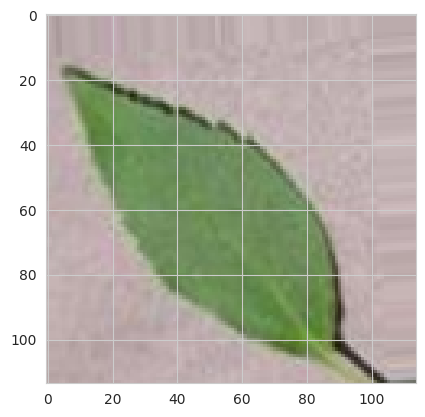

In [15]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)   #  (1,114,114,3)
    plt.imshow(img[0])
    plt.show()

**Plot Test Augmented Images**

(16, 114, 114, 3)


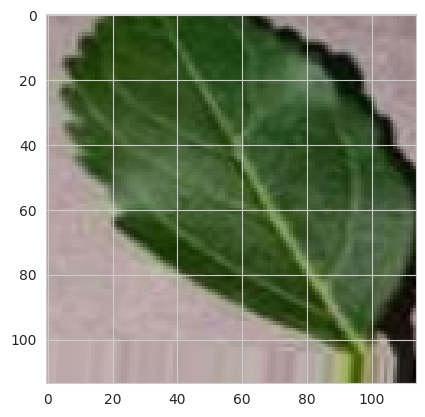

(16, 114, 114, 3)


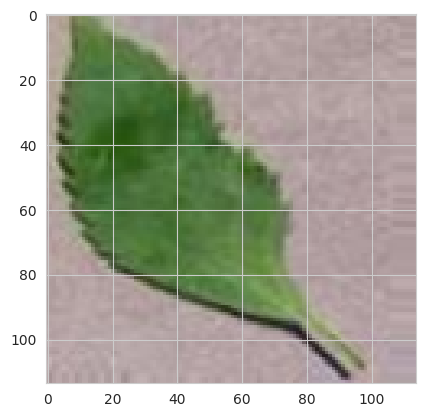

(16, 114, 114, 3)


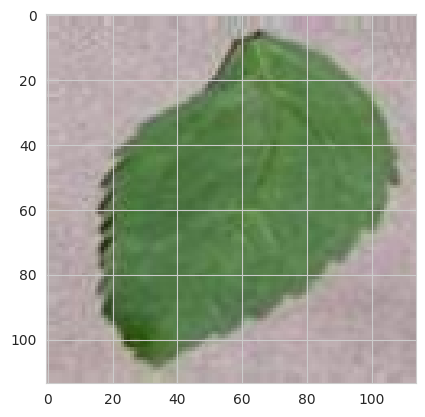

In [16]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)   #  (1,114,114,3)
    plt.imshow(img[0])
    plt.show()

**Save class_indices**

In [17]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

# Section 3

## Model creation

We define a Convolutional Neural Network (CNN) to classify the images of cherry leaves. CNNs are particularly effective for image classification tasks due to their ability to capture spatial hierarchies in images.

**Relevant Resources:**
- [Conv2D Layer Documentation](https://keras.io/api/layers/convolution_layers/convolution2d/): Learn more about the Conv2D layer, which applies a convolution operation to the input.
- [Sequential Model Documentation](https://keras.io/guides/sequential_model/): The Sequential model is a linear stack of layers, suitable for most deep learning tasks.


### **ML model**

**Model**

In [18]:
# CNN model
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

**Model Summary**

In [19]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

2024-08-27 04:35:49.975094: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Early Stopping**

In [20]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)

**Fit model for model training**

In [21]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

2024-08-27 04:35:57.232885: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
184/184 [==============================] - 48s 261ms/step - loss: 0.3010 - accuracy: 0.8567 - val_loss: 0.0462 - val_accuracy: 0.9952
Epoch 2/20
184/184 [==============================] - 50s 270ms/step - loss: 0.0609 - accuracy: 0.9776 - val_loss: 0.0316 - val_accuracy: 0.9929
Epoch 3/20
184/184 [==============================] - 48s 262ms/step - loss: 0.0348 - accuracy: 0.9878 - val_loss: 0.0617 - val_accuracy: 0.9905
Epoch 4/20
184/184 [==============================] - 49s 265ms/step - loss: 0.0361 - accuracy: 0.9895 - val_loss: 0.0509 - val_accuracy: 0.9976
Epoch 5/20
184/184 [==============================] - 49s 266ms/step - loss: 0.0242 - accuracy: 0.9929 - val_loss: 0.0544 - val_accuracy: 0.9976


**Save model**

In [22]:
model.save('outputs/v1/cherry_leaves_model.h5')

## Model Performace

**Model learning curve**

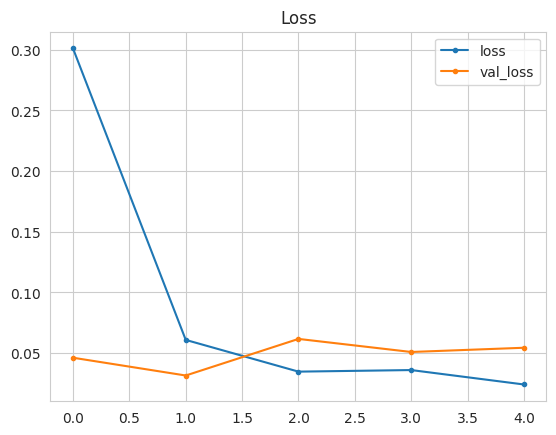

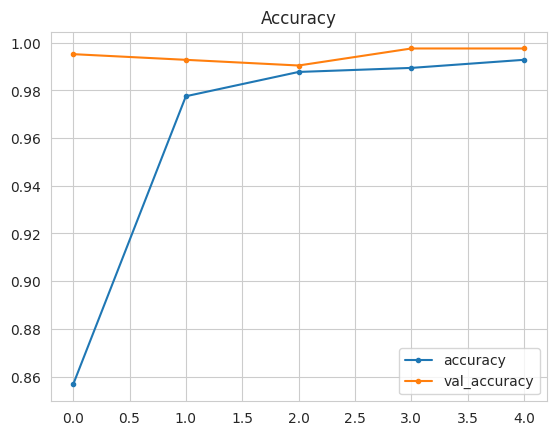

In [23]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

After training the model, we evaluate its performance on the test dataset. The evaluation will be based on accuracy and loss metrics, as well as confusion matrices and classification reports.

**Relevant Resources:**
- [Model Evaluation Documentation](https://keras.io/api/models/model_training_apis/#evaluate-method): Learn more about evaluating a model in Keras.
- [Classification Report Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html): Learn more about the classification report, which provides a detailed breakdown of the model’s performance.
- [Confusion Matrix Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html): Learn more about the confusion matrix, which helps visualize the performance of the model.


In [24]:
# Evaluate the model on the test set
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_model.h5')

In [25]:
evaluation = model.evaluate(test_set)

53/53 [==============================] - 4s 70ms/step - loss: 0.0041 - accuracy: 0.9976


**Save evaluation pickle**

In [26]:
joblib.dump(value=evaluation ,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

**Load a random image as PIL**

 Image shape: (114, 114), Image mode: RGB


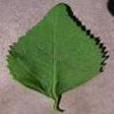

In [27]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0] 
pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/' + label)[pointer],
                            target_size= image_shape, color_mode='rgb')

print(f" Image shape: {pil_image.size}, Image mode: {pil_image.mode}")
pil_image

**Convert image to array and prepare for prediction**

In [28]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)
print(my_image.shape)

(1, 114, 114, 3)


**Predict class probabilities**

In [29]:
# Ensure your input is a tensor and check the shape remains the same
my_image = tf.convert_to_tensor(my_image)

# Making predictions
pred_proba = model.predict(my_image)[0, 0]

# Assuming binary classification; adjust the threshold as needed
target_map = {v: k for k, v in train_set.class_indices.items()}

# Use numpy or a similar approach to manage tensor operations instead of Python objects
import numpy as np
pred_class = target_map[np.argmax([1 - pred_proba, pred_proba])] 

# If the predicted class is the first class (binary), adjust the probability
if pred_class == target_map[0]: 
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)


1.0
healthy


---

# Push files to Repo

## Push generated/new files from this Session to GitHub repo

* Context Setup

In [30]:
!pwd


/workspace/rare-and-sweet


* Listing Files

In [31]:
!ls -a


.	   .github	       jupyter_notebooks  requirements.txt  .vscode
..	   .gitignore	       kaggle.json	  runtime.txt
app_pages  .gitpod.dockerfile  outputs		  setup.sh
app.py	   .gitpod.yml	       Procfile		  .slugignore
.git	   inputs	       README.md	  src


.gitignore

The .gitignore file is well-configured to prevent unnecessary or sensitive files from being committed. This helps in keeping the repository clean and secure.

In [32]:
!cat /workspace/rare-and-sweet/.gitignore


core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json

* Git Status

In [33]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/0008f3d3-2f85-4973-be9a-1b520b8b59fc___JR_HL 4092_180deg.JPG
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/005f183c-0a73-4738-91f7-c0a0e02cd9e3___JR_HL 9679.JPG
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/0086a8c7-1440-423e-939d-d0567b1fc4e4___JR_HL 4277.JPG
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/00a8e886-d172-4261-85e2-780b3c50ad4d___JR_HL 4156.JPG
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/011f07d1-8813-4a63-99c7-e274ab5cc261___JR_HL 4165_flipTB.JPG
	modified:   inputs/cherry-leaves_dataset/cherry-leaves/test/healthy/014161fb-3c15-414b-9af3-00cb51a11d7c___JR_HL 9842_180deg.JPG
	modified:   in

* Staging Changes, Commit and Push

In [34]:
!git add .

In [35]:
!git commit -m "Resize images to 114x114 pixels to fit Heroku slug size constraints"

[main f50f2181] Resize images to 114x114 pixels to fit Heroku slug size constraints
 4218 files changed, 57 insertions(+), 67 deletions(-)
 create mode 100644 outputs/avg_diff.png


In [36]:
!git push

Enumerating objects: 5081, done.
Counting objects: 100% (5081/5081), done.
Delta compression using up to 32 threads
Compressing objects: 100% (4231/4231), done.
Writing objects: 100% (4235/4235), 25.33 MiB | 15.30 MiB/s, done.
Total 4235 (delta 8), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (8/8), completed with 8 local objects.
To https://github.com/c-argus/rare-and-sweet.git
   6d0b6aa6..f50f2181  main -> main
